[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/TobGerken/ISAT300/blob/main/Lab3_ThermoCoupleData.ipynb)

# Temperature Response Lab - Reading the Thermocouple Data 

**This notebook is published on my github. It is publicly accessible, but you cannot save your changes to my github. Learning git & github is beyond the scope of this course. If you are familiar with github, you know that to do. If you don't know github, you can save a personal copy of the file to your google drive, so that you can save your changes and can access them at a later date**

This notebook is a continuation from previous classes:

1. [GettingStarted](https://github.com/TobGerken/ISAT300/blob/main/1_GettingStarted.ipynb)
2. [Data Visualization](https://github.com/TobGerken/ISAT300/blob/main/2_DataVisualization.ipynb)
3. [Heart Rate Lab Review](https://github.com/TobGerken/ISAT300/blob/main/3_HeartRateLabReview.ipynb)

We also walk throught the steps of the temperature response using the LabQuest sensor data

- [Temperature Response Review](https://github.com/TobGerken/ISAT300/blob/main/4_TemperatureResponseLabReview.ipynb)

## Before we start

This code uses the same techniques as previous notebooks. 

Additionally, we will learn how to read the data that you collected during the Thermocouple Lab into a jupyter notebook. 

In this notebook we will:

- Load lab data into a dataframe
- Plot the data as a timeseries
- Isolate the data of a single step-response (i.e. cold to hot)
- Fit an exponential model (see below) to estimate the time constant $\tau$ 
    
     **$y(t) = A + B \times e^{-([t-T]/\tau)}$**


You shoul'd definitely know how to estimate *A, B,* and *T* provided experimental data. And you should also be able to calculate $\tau$ assuming that you have *A, B, T* and data for *t* and *y(t)*. 


In [2]:
# running this will import pandas and numpy.
import pandas as pd
import numpy as np

We are now loading the data into a pandas dataframe. I have uploaded sample data from one of your groups to GitHub.

In [57]:
df= pd.read_csv('https://raw.githubusercontent.com/TobGerken/ISAT300/main/Data/Lab3_Thermocouple_2.csv')
#df= pd.read_csv('./Data/Lab3_Thermocouple_2.csv')
df.head()


,Time,Temperature
0,2025-02-14 10:53:18.786357,0.546875
1,2025-02-14 10:53:18.943447,0.554688
2,2025-02-14 10:53:19.101079,0.679688
3,2025-02-14 10:53:19.257913,0.593750
4,2025-02-14 10:53:19.416339,0.656250


We can see that the data was loaded and that we both have a column with a timestamp and a column with temperature. 

Let's make a plot:

<AxesSubplot:>

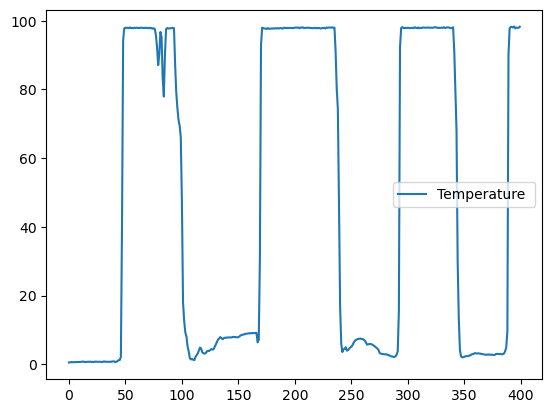

In [59]:
df.plot()

This looks a bit weird, we would want to plot the time on the x-axis, but we are getting something else.

If we use the `.info()` method, we get a bit more information about our dataframe. 

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Time          400 non-null    object 
 1   Temperature   400 non-null    float64
dtypes: float64(1), object(1)
memory usage: 6.4+ KB


One thing that we notice is that the `Time` column has the data type (`Dtype`) "Object", while the temerpature is a `float`, which means its a number. 

To make _pandas_ understand that this is actually a time, we can use the `.to_datetime()` method, which will translate this to a times. 

In [63]:
df['Time']= pd.to_datetime(df['Time'])
df.head()

,Time,Temperature
0,2025-02-14 10:53:18.786357,0.546875
1,2025-02-14 10:53:18.943447,0.554688
2,2025-02-14 10:53:19.101079,0.679688
3,2025-02-14 10:53:19.257913,0.593750
4,2025-02-14 10:53:19.416339,0.656250


This does not look any different, but using `.info()` again, we see that the `'Time'` column is now of type datetime . 

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Time          400 non-null    datetime64[ns]
 1   Temperature   400 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.4 KB


In [ ]:
We can now create a scatter plot of _Time_ v _Temperature_:

<AxesSubplot:xlabel='Time', ylabel='Temperature '>

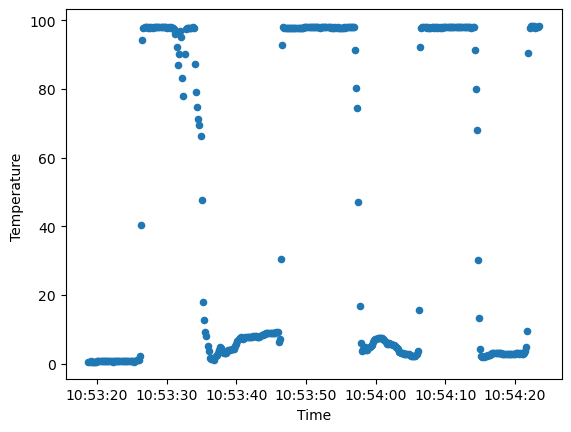

In [16]:
df.plot(kind = 'scatter', x = 'Time', y = 'Temperature ')

Note that I wrote `'Temperature '`, because the column in that particular groups file had an extra space. We can see this by getting the column names with `.columns`: 

In [15]:
df.columns

Index(['Time', 'Temperature '], dtype='object')

To make things a bit easier, I am subtracting the first timestamp from the `'Time'` column to just have the number of seconds since the start: 

`df['Time'].iloc[0]` is the first entry in the `'Time'` column.

The `.dt.total_seconds()` method converts the calculated time difference to seconds: 

In [67]:
df['Time_sec'] = (df['Time']-df['Time'].iloc[0]).dt.total_seconds()

Now plotting it again, looks better: 

<AxesSubplot:xlabel='Time_sec', ylabel='Temperature '>

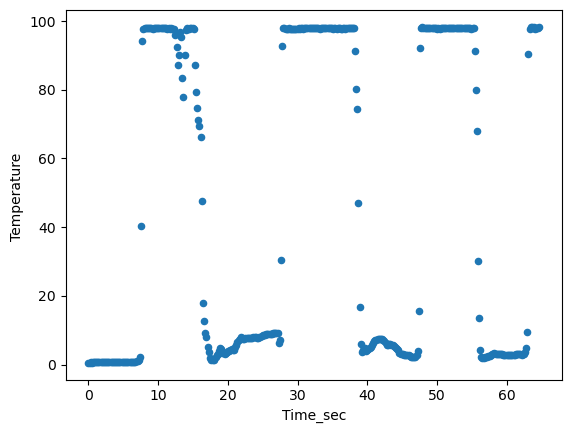

In [69]:
df.plot(kind = 'scatter', x = 'Time_sec', y = 'Temperature ')

### Analyzing the data

To make sense of this data, we want to zoom in and look at a single jump. 

To do so, we can use a logical comparions selecting only the times that we are interested in: 

C:\Users\gerkentx\AppData\Local\Temp\ipykernel_22780\3607945724.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_cold2hot = df_jump[selectedTime]


<AxesSubplot:xlabel='Time_sec', ylabel='Temperature '>

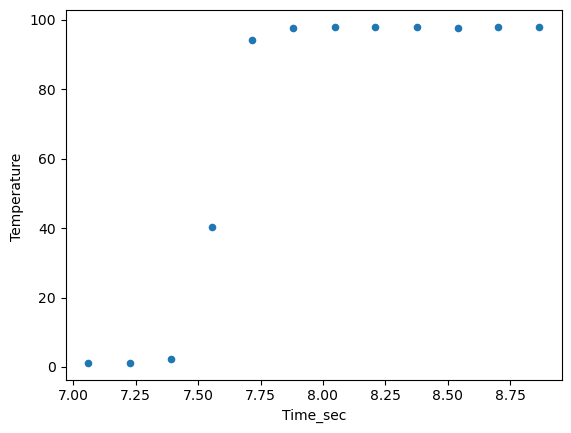

In [72]:
# Create a copy of our data
df_cold2hot = df.copy()
# we now create a logical array to select only data between 7 and 9 seconds
selectedTime = (df_cold2hot['Time_sec']<9) & (df_cold2hot['Time_sec']>7)
# we now use this to select that data 
df_cold2hot = df_jump[selectedTime]
# and finally plot itFitting the model

We can like last week use curve_fit() from the Scipy package in python to our step-response function to estimate the set of fitted parameters.

To do so we have to:

    import curve_fit
    define our first-order step response function
    apply the curve fit
    use the curve fit to estimate the temperature values for plotting

df_cold2hot.plot(kind = 'scatter', x = 'Time_sec', y = 'Temperature ')

## Fitting the model

We can like last week use `curve_fit()` from the [Scipy](https://scipy.org/) package in python to our step-response function to estimate the set of fitted parameters.  

To do so we have to:

- import `curve_fit`
- define our first-order step response function
- apply the curve fit 
- use the curve fit to estimate the temperature values for plotting

In [73]:
from scipy.optimize import curve_fit

def FirstOrderResponse(t, a, b, T, tau):
    y = a + b * np.exp(-(t-T)/tau)
    y[t<T]= a+b # This is needed to enforce the step nature of the model.
    return y

# It is often a good idea to supply the first guess of the parameters, to make sure that the algorithm does not get stuck.

# First guess for values
a   = 100        # suggested starting value: 0
b   = 0-100       # suggested starting value: 100
T   = 7.5
tau = .2
firstGuess = [a,b,T,tau]

# We also extract time and temperature to shorten the code
t = df_cold2hot['Time_sec']
y = df_cold2hot['Temperature ']


# We can now call again the curve_fit. 
fittedParameter, variance = curve_fit(FirstOrderResponse, t, y, firstGuess)
print(fittedParameter)

# This then apply the fit to get estimated values for Temperature

# The first one is using many points, to actually see the fitted curve:
y_est_many_points = FirstOrderResponse(np.linspace(7,9,100),fittedParameter[0],fittedParameter[1],fittedParameter[2],fittedParameter[3])
# The second one is for just the points with measurements to compare measured and modeled 
y_est_original_points = FirstOrderResponse(t,fittedParameter[0],fittedParameter[1],fittedParameter[2],fittedParameter[3])

[ 9.79225899e+01 -9.63913399e+01  7.52329061e+00  5.94822428e-02]


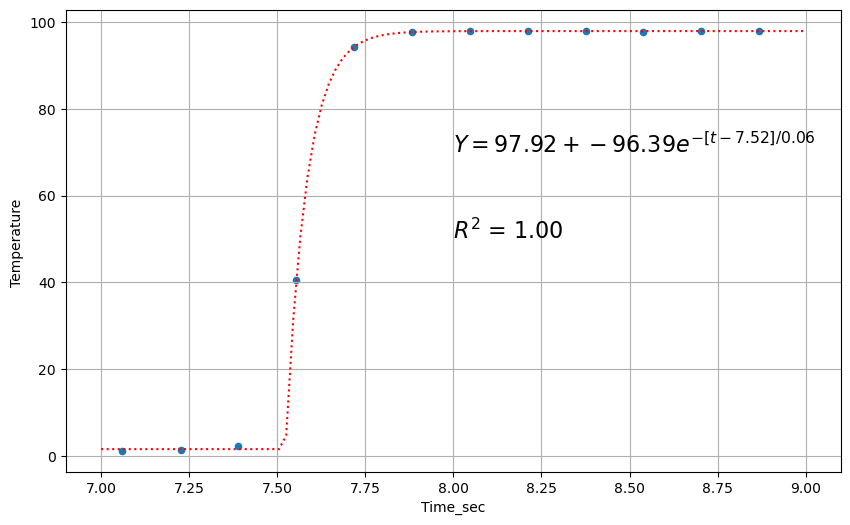

In [74]:
import matplotlib.pyplot as plt
ax1 = df_jump.plot(kind = 'scatter', x = 'Time_sec', y = 'Temperature ', grid = True, figsize=(10, 6))
ax1 = plt.plot(np.linspace(7,9,100),y_est_many_points, color = 'r', linestyle=':')
ax1 = plt.text(8, 70, r"$Y = %3.2f +  %3.2f e^{- [t - %3.2f] / %3.2f }$" % (fittedParameter[0],fittedParameter[1],fittedParameter[2],fittedParameter[3]), fontsize = 16)
ax1 = plt.text(8, 50, r"$R^2$ = %3.2f" % (np.corrcoef(y,y_est_original_points)[0,1])**2 , fontsize = 16)
